In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('drive')


Mounted at /content/drive


In [82]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import os

# Set visualization styles
sns.set_style('darkgrid')
plt.style.use("fivethirtyeight")

In [83]:
# Define dataset paths
data_path = 'MAANGDATA'
    "GOOGLE": "GOOG",
    "AMAZON": "AMZN",
    "APPLE": "AAPL",
    "META": "META",
    "NETFLIX": "NFLX"
}

# Load daily stock data
def load_stock_data():
    daily_files = {name: os.path.join(data_path, f"{name}_daily.csv") for name in companies.keys()}
    dataframes = {}
    for name, path in daily_files.items():
        df = pd.read_csv(path, parse_dates=['Date'])
        df['Ticker'] = companies[name]
        dataframes[companies[name]] = df
    return dataframes

dataframes = load_stock_data()


In [84]:
# Combine all data into a single DataFrame
combined_df = pd.concat(dataframes.values(), ignore_index=True)

# Sort and clean the data
combined_df = combined_df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
print("Data loaded successfully!")

# Plot candlestick charts
def create_candlestick(df, ticker):
    figure = go.Figure(data=[go.Candlestick(
        x=df["Date"],
        open=df["Open"],
        high=df["High"],
        low=df["Low"],
        close=df["Close"],
        increasing_line_color='cyan', decreasing_line_color='red'
    )])
    figure.update_layout(
        title=f"{ticker} Stock Prices",
        xaxis_rangeslider_visible=False
    )
    figure.show()

for ticker in companies.values():
    create_candlestick(combined_df[combined_df['Ticker'] == ticker], ticker)

Data loaded successfully!


In [85]:
# Calculate moving averages
for ticker in companies.values():
    combined_df.loc[combined_df['Ticker'] == ticker, 'MA20'] = combined_df.loc[
        combined_df['Ticker'] == ticker, 'Close'].rolling(window=20, min_periods=1).mean()
    combined_df.loc[combined_df['Ticker'] == ticker, 'MA40'] = combined_df.loc[
        combined_df['Ticker'] == ticker, 'Close'].rolling(window=40, min_periods=1).mean()

# Plot moving averages
for ticker in companies.values():
    data = combined_df[combined_df['Ticker'] == ticker]
    fig = px.line(
        data, x='Date', y=['Close', 'MA20', 'MA40'],
        title=f"{ticker} Stock Price with Moving Averages",
        labels={'value': 'Price', 'variable': 'Metric'}
    )
    fig.show()

In [86]:
# LSTM Model for Netflix
nflx_df = combined_df[combined_df['Ticker'] == 'NFLX'][['Date', 'Close']].copy()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(nflx_df['Close'].values.reshape(-1, 1))

# Prepare training and testing data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 100:]


In [88]:
# Create sequences for LSTM
def create_sequences(data, sequence_length=100):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data)
x_test, y_test = create_sequences(test_data)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [89]:
from tensorflow.keras import Input

# Build LSTM model with Input layer
model = Sequential([
    Input(shape=(x_train.shape[1], 1)),  # Explicitly specify input shape
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - loss: 0.0026
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - loss: 2.7290e-04
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - loss: 2.1939e-04
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 2.1466e-04
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - loss: 2.0865e-04
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 1.9584e-04
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 1.9991e-04
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - loss: 1.6300e-04
Epoch 9/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - loss: 1.5892e-04
Epoch 10/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 1.5743e-04
Epoch 11/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 1.6262e-04
Epoch 12/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 1.5686e-04
Epoch 13/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - loss: 1.6116e-04
Epoch 14/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 100m

In [90]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


In [91]:
# Evaluate RMSE
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 26.561035202410622


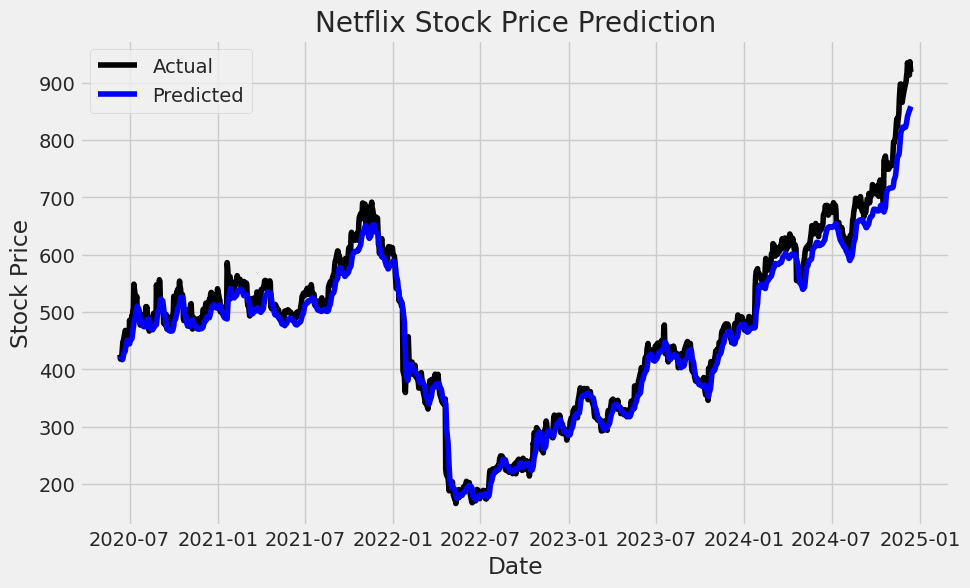

In [92]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(nflx_df['Date'][-len(y_test):], y_test, color='black', label='Actual')
plt.plot(nflx_df['Date'][-len(predictions):], predictions, color='blue', label='Predicted')
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()